In [1]:
import torch
import torchvision.transforms as transforms 
import torch.nn.init
from torchsummary import summary as summary_
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets

In [2]:
#Train data 받아오기
class_num = list(0. for i in range(5))

path_dir = 'LJH/data/product_data/train/Item-Parse_f' #Parse 폴더에서 파일명 불러오기
file_list_train = os.listdir(path_dir)

In [3]:
TRAIN_SIZE = len(file_list_train)
label = [0 for i in range(TRAIN_SIZE)] #list형
path_dir_img = 'train'

def make_file_list():
    #train_img_list = [0 for i in range(len(file_list_train))]
    train_img_list = [0 for i in range(TRAIN_SIZE)]
    cnt = 0
    #for i in file_list_train:
    for i in range(TRAIN_SIZE):
    
        with open(path_dir +'/'+ file_list_train[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        class_num[category]+=1
        #print(category)
        str = file_list_train[cnt].split('.')[0]
        train_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label[cnt] = category

        cnt+=1

    return train_img_list


In [4]:
"""train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])



print(train_meanR, train_meanG, train_meanB)"""

'train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]\ntrain_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]\n\ntrain_meanR = np.mean([m[0] for m in train_meanRGB])\ntrain_meanG = np.mean([m[1] for m in train_meanRGB])\ntrain_meanB = np.mean([m[2] for m in train_meanRGB])\ntrain_stdR = np.mean([s[0] for s in train_stdRGB])\ntrain_stdG = np.mean([s[1] for s in train_stdRGB])\ntrain_stdB = np.mean([s[2] for s in train_stdRGB])\n\n\n\nprint(train_meanR, train_meanG, train_meanB)'

In [5]:
class ImageTransform():

    def __init__(self):
        
        self.data_transform = transforms.Compose([
            #transforms.CenterCrop(720),
            #transforms.Resize(256),
            #transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
            transforms.ToTensor(),
        ])
        

    def __call__(self, img):
        return self.data_transform(img)

In [6]:
class Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_label = label[index]

        return img_transformed,img_label

In [7]:
train_img_list=make_file_list()

In [8]:
for i in range(5):
    print(class_num[i])

210.0
4984.0
20218.0
7304.0
454.0


In [9]:
train_dataset = Img_Dataset(file_list=train_img_list,
                            transform=ImageTransform())

In [10]:
train_dataloader = data.DataLoader(train_dataset,
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True)
print('Dataloader created')

Dataloader created


In [11]:
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [12]:
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [34]:
class VGG11(nn.Module):
    def __init__(self,init_weights: bool = True):
        super(VGG11, self).__init__()
        self.convnet = nn.Sequential(
            # Input Channel (RGB: 3)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )

        self.fclayer = nn.Sequential(
            nn.Linear(512 * 8 * 8, 4096),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 5),
        )
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        x = self.fclayer(x)
        return x

In [35]:
from torchsummary import summary as summary_
DEVICE_IDS = [0,1]
model = VGG11().to(device)
summary_(model,(3,256,256),batch_size = 128)
VGG11 = torch.nn.parallel.DataParallel(VGG11, device_ids=DEVICE_IDS)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 256, 256]           1,792
         LeakyReLU-2        [128, 64, 256, 256]               0
         MaxPool2d-3        [128, 64, 128, 128]               0
            Conv2d-4       [128, 128, 128, 128]          73,856
         LeakyReLU-5       [128, 128, 128, 128]               0
         MaxPool2d-6         [128, 128, 64, 64]               0
            Conv2d-7         [128, 256, 64, 64]         295,168
         LeakyReLU-8         [128, 256, 64, 64]               0
            Conv2d-9         [128, 256, 64, 64]         590,080
        LeakyReLU-10         [128, 256, 64, 64]               0
        MaxPool2d-11         [128, 256, 32, 32]               0
           Conv2d-12         [128, 512, 32, 32]       1,180,160
        LeakyReLU-13         [128, 512, 32, 32]               0
           Conv2d-14         [128, 512,

In [36]:
criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [37]:
total_batch = len(train_dataloader)
for epoch in range(10): 
    avg_cost = 0 
    cnt = 0
    
    for X, Y in train_dataloader: 
        X = X.to(device) 
        Y = Y.to(device) 
        
        optimizer.zero_grad() 
        hypothesis = model(X) 
        cost = criterion(hypothesis, Y) 
        cost.backward() 
        optimizer.step() 
       
        avg_cost += cost / total_batch
           
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.850465715
[Epoch:    2] cost = 0.402423322
[Epoch:    3] cost = 0.297045708
[Epoch:    4] cost = 0.25243023
[Epoch:    5] cost = 0.223384812
[Epoch:    6] cost = 0.19926475
[Epoch:    7] cost = 0.178553224
[Epoch:    8] cost = 0.158359453
[Epoch:    9] cost = 0.137336671
[Epoch:   10] cost = 0.124686763


In [38]:
path_dir = 'LJH/data/product_data/test/Item-Parse_f'
path_dir_img = 'test'
file_list_test = os.listdir(path_dir)
Test_size = len(file_list_test)
#label_test = [0 for i in range(len(file_list_test))] #list형
label_test = [0 for i in range(Test_size)] 
def make_file_list_test():
    #test_img_list = [0 for i in range(len(file_list_test))]
    test_img_list = [0 for i in range(Test_size)]
    cnt = 0
    #for i in file_list_test:
    for i in range(Test_size):
    
        with open(path_dir +'/'+ file_list_test[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        #print(category)
        str = file_list_test[cnt].split('.')[0]
        test_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label_test[cnt] = category

        cnt+=1

    return test_img_list

In [39]:
class Img_Dataset_test(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_label = label_test[index]

        return img_transformed,img_label

In [40]:
test_img_list=make_file_list_test()

In [41]:
"""# test set 전처리

from torchvision.transforms import ToTensor
X_test = torch.empty(0,3,256,256)


image_w = 256 
image_h = 256
cnt_img = 0
for j in test_img_list:
    image = Image.open(test_img_list[cnt_img])
    image = image.crop((0,280,720,1000))
    image = image.resize((256, 256))
    data = ToTensor()(image).unsqueeze(0)
    X_test =torch.cat([X_test,data],dim=0)
    cnt_img += 1
    if cnt_img % 1000 == 0:
        print(cnt_img)"""

'# test set 전처리\n\nfrom torchvision.transforms import ToTensor\nX_test = torch.empty(0,3,256,256)\n\n\nimage_w = 256 \nimage_h = 256\ncnt_img = 0\nfor j in test_img_list:\n    image = Image.open(test_img_list[cnt_img])\n    image = image.crop((0,280,720,1000))\n    image = image.resize((256, 256))\n    data = ToTensor()(image).unsqueeze(0)\n    X_test =torch.cat([X_test,data],dim=0)\n    cnt_img += 1\n    if cnt_img % 1000 == 0:\n        print(cnt_img)'

In [42]:
#print(X_test.shape)

In [43]:
#Y_test = torch.tensor(label_test)

In [44]:
test_dataset = Img_Dataset_test(file_list=test_img_list, transform=ImageTransform())

In [45]:
test_dataloader = data.DataLoader(test_dataset,
                                   batch_size=32,
                                   shuffle=False,
                                   drop_last=True)

In [46]:
#Testing classification accuracy for individual classes.
correct = 0
total = 0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
arr = [[0]*5 for i in range(5)]
with torch.no_grad():
    for datas in test_dataloader:
        images, labels = datas[0].to(device), datas[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(32):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            arr[label][predicted[i]] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

for i in range(5):
    print('Accuracy of %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))
print('total Accurarcy : %2d %%' %(100 * correct / total))
print()
print('Num  of total : %2d / %2d  ' %(correct, total))
for i in range(5):
    print('Num of %d : %2d / %2d' % (
        i, class_correct[i], class_total[i]))

Accuracy of 0 : 100 %
Accuracy of 1 : 80 %
Accuracy of 2 : 97 %
Accuracy of 3 : 99 %
Accuracy of 4 : 98 %
total Accurarcy : 96 %

Num  of total : 7591 / 7904  
Num of 0 : 24 / 24
Num of 1 : 720 / 889
Num of 2 : 4051 / 4176
Num of 3 : 2717 / 2735
Num of 4 : 79 / 80


In [47]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

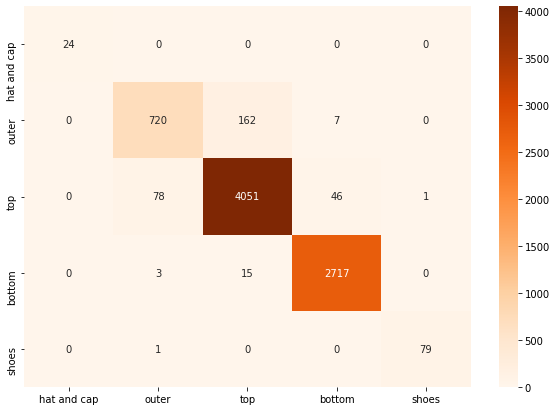

In [48]:
classes = ["hat and cap", "outer", "top", "bottom","shoes"]
df_cfm = pd.DataFrame(arr, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True, cmap='Oranges', fmt='g')